First lets get an environment for our agent.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import time
from matplotlib.ticker import FormatStrFormatter


class GridWorld:
    def __init__(self, filename, reward, random_rate, time_limit=1000):
        file = open(filename)
        self.map = np.array(
            [list(map(float, s.strip().split(","))) for s in file.readlines()]
        )
        file.close()
        self.num_rows = self.map.shape[0]
        self.num_cols = self.map.shape[1]
        self.num_states = self.num_rows * self.num_cols
        self.num_actions = 4
        self.reward = reward
        self.random_rate = random_rate
        self.time_limit = time_limit
        self.reward_function = self.get_reward_function()
        self.transition_model = self.get_transition_model()

    def get_state_from_pos(self, pos):
        return pos[0] * self.num_cols + pos[1]

    def get_pos_from_state(self, state):
        return state // self.num_cols, state % self.num_cols

    def get_reward_function(self):
        reward_table = np.zeros(self.num_states)
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                s = self.get_state_from_pos((r, c))
                reward_table[s] = self.reward[self.map[r, c]]
        return reward_table

    def get_transition_model(self):
        transition_model = np.zeros((self.num_states, self.num_actions, self.num_states))
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                s = self.get_state_from_pos((r, c))
                neighbor_s = np.zeros(self.num_actions)
                if self.map[r, c] == 0:
                    for a in range(self.num_actions):
                        new_r, new_c = r, c
                        if a == 0:
                            new_r = max(r - 1, 0)
                        elif a == 1:
                            new_c = min(c + 1, self.num_cols - 1)
                        elif a == 2:
                            new_r = min(r + 1, self.num_rows - 1)
                        elif a == 3:
                            new_c = max(c - 1, 0)
                        if self.map[new_r, new_c] == 3:
                            new_r, new_c = r, c
                        s_prime = self.get_state_from_pos((new_r, new_c))
                        neighbor_s[a] = s_prime
                else:
                    neighbor_s = np.ones(self.num_actions) * s
                for a in range(self.num_actions):
                    transition_model[s, a, int(neighbor_s[a])] += 1 - self.random_rate
                    transition_model[s, a, int(neighbor_s[(a + 1) % self.num_actions])] += self.random_rate / 2.0
                    transition_model[s, a, int(neighbor_s[(a - 1) % self.num_actions])] += self.random_rate / 2.0
        return transition_model

    def generate_random_policy(self):
        return np.random.randint(self.num_actions, size=self.num_states)

    def execute_policy(self, policy, start_pos):
        s = self.get_state_from_pos(start_pos)
        r = self.reward_function[s]
        total_reward = r

        start_time = int(round(time() * 1000))
        overtime = False

        while r != self.reward[1] and r != self.reward[2]:
            s = np.random.choice(self.num_states, p=self.transition_model[s, policy[s]])
            r = self.reward_function[s]
            total_reward += r
            cur_time = int(round(time() * 1000)) - start_time
            if cur_time > self.time_limit:
                overtime = True
                break
        if overtime is True:
            return float('-inf')
        else:
            return total_reward

    def random_start_policy(self, policy, start_pos, n=100, plot=True):
        start_time = int(round(time() * 1000))
        overtime = False
        scores = np.zeros(n)
        i = 0
        while i < n:
            temp = self.execute_policy(policy=policy, start_pos=start_pos)
            print(f'i = {i} Random start result: {temp}')
            if temp > float('-inf'):
                scores[i] = temp
                i += 1
            cur_time = int(round(time() * 1000)) - start_time
            if cur_time > n * self.time_limit:
                overtime = True
                break

        print(f'max = {np.max(scores)}')
        print(f'min = {np.min(scores)}')
        print(f'mean = {np.mean(scores)}')
        print(f'std = {np.std(scores)}')

        if overtime is False and plot is True:
            bins = 100
            fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
            ax.set_xlabel('Total rewards in a single game')
            ax.set_ylabel('Frequency')
            ax.hist(scores, bins=bins, color='#1f77b4', edgecolor='black')
            plt.show()

        if overtime is True:
            print('Overtime!')
            return None
        else:
            return np.max(scores), np.min(scores), np.mean(scores)

    def blackbox_move(self, s, a):
        temp = self.transition_model[s, a]
        s_prime = np.random.choice(self.num_states, p=temp)
        r = self.reward_function[s_prime]
        return s_prime, r

    def plot_map(self, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')
        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)

        plt.tight_layout()
        plt.show()

    def plot_policy(self, policy, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')
        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                s = self.get_state_from_pos((i, j))
                if self.map[i, j] == 0:
                    a = policy[s]
                    symbol = ['^', '>', 'v', '<']
                    ax.plot([x + 0.5 * unit], [y + 0.5 * unit], marker=symbol[a],
                            linestyle='none', markersize=max(fig_size)*unit, color='#1f77b4')

        plt.tight_layout()
        plt.show()

    def visualize_value_policy(self, policy, values, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')

        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                s = self.get_state_from_pos((i, j))
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                if self.map[i, j] != 3:
                    ax.text(x + 0.5 * unit, y + 0.5 * unit, f'{values[s]:.4f}',
                            horizontalalignment='center', verticalalignment='center',
                            fontsize=max(fig_size)*unit*0.6)
                if policy is not None:
                    if self.map[i, j] == 0:
                        a = policy[s]
                        symbol = ['^', '>', 'v', '<']
                        ax.plot([x + 0.5 * unit], [y + 0.5 * unit], marker=symbol[a], alpha=0.4,
                                linestyle='none', markersize=max(fig_size)*unit, color='#1f77b4')

        plt.tight_layout()
        plt.show()

Next we will create our QLearner agent to act in our environment.

In [3]:
class QLearner:
    def __init__(self, num_states, num_actions, alpha=0.2, gamma=0.9, epsilon=0.9, xi=0.99):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.xi = xi
        self.cur_policy = np.random.randint(num_actions, size=num_states)
        self.q_table = np.zeros((num_states, num_actions))

    def percept(self, s, a, s_prime, r):
        q_prime = np.max(self.q_table[s_prime])
        old_q_value = self.q_table[s, a]
        learned_value = r + self.gamma * q_prime - old_q_value
        self.q_table[s, a] += self.alpha * learned_value
        self.cur_policy[s] = np.argmax(self.q_table[s])

    def actuate(self, s):
        if np.random.uniform() <= self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return self.cur_policy[s]

    def update_episode(self):
        self.epsilon *= self.xi

Finally, lets get our problem solver class ready and import an example problem to solve using gridworld.

In [4]:
class GridWorldQSolver:
    def __init__(self, problem, learner_class, epsilon=0.9, xi=0.99):
        self.problem = problem
        self.learner = learner_class(num_states=problem.num_states, num_actions=problem.num_actions, epsilon=epsilon, xi=xi)

    def train_one_epoch(self, start_pos):
        s = self.problem.get_state_from_pos(start_pos)
        if_win = 0
        reward_game = 0
        while True:
            a = self.learner.actuate(s)
            s_prime, r = self.problem.blackbox_move(s, a)
            self.learner.percept(s, a, s_prime, r)
            reward_game += r
            if r == self.problem.reward[1]:
                if_win = 1
                break
            elif r == self.problem.reward[2]:
                break
            else:
                s = s_prime
        self.learner.update_episode()
        return reward_game, if_win

    def train(self, epochs, start_pos, plot=True):
        reward_history = np.zeros(epochs)
        total_reward_history = np.zeros(epochs)
        total_reward = 0
        game_win = np.zeros(epochs)

        time_start = int(round(time() * 1000))
        for i in range(epochs):
            print(f'Training epoch {i + 1}')
            reward_episode, win_episode = self.train_one_epoch(start_pos=start_pos)
            total_reward += reward_episode
            game_win[i] = win_episode
            reward_history[i] = reward_episode
            total_reward_history[i] = total_reward
        time_end = int(round(time() * 1000))
        print(f'time used = {time_end - time_start}')
        print(f'final reward = {total_reward}')

        segment = 10
        game_win = game_win.reshape((segment, epochs // segment))
        game_win = np.sum(game_win, axis=1)

        if plot:
            fig, axes = plt.subplots(2, 1, figsize=(5, 4), dpi=200, sharex='all')
            axes[0].plot(np.arange(len(total_reward_history)), total_reward_history,
                         alpha=0.7, color='#d62728', label=r'$\xi$ = ' + f'{self.learner.xi}')
            axes[0].set_ylabel('Total rewards')
            axes[0].legend(loc='best')
            axes[1].plot(np.arange(len(reward_history)), reward_history, marker='o', markersize=2,
                         alpha=0.7, color='#2ca02c', linestyle='none')
            axes[1].set_xlabel('Episode')
            axes[1].set_ylabel('Reward from\na single game')
            # axes[1].set_ylim(-1000, 100)
            axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            axes[0].grid(axis='x')
            axes[1].grid(axis='x')
            plt.tight_layout()
            plt.show()

            fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=200)
            ax.plot(np.arange(1, segment + 1) * (epochs // segment), game_win / (epochs // segment), marker='o',
                    markersize=2,
                    alpha=0.7, color='#2ca02c',
                    label=r'$\xi$ = ' + f'{self.learner.xi}')
            ax.set_ylabel('Winning percentage')
            ax.set_xlabel('Episode')
            plt.legend(loc='best')
            plt.tight_layout()
            plt.show()

Okay lets see our agent in action(the csv of gridworld will be included in the submission files):

Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Training epoch 15
Training epoch 16
Training epoch 17
Training epoch 18
Training epoch 19
Training epoch 20
Training epoch 21
Training epoch 22
Training epoch 23
Training epoch 24
Training epoch 25
Training epoch 26
Training epoch 27
Training epoch 28
Training epoch 29
Training epoch 30
Training epoch 31
Training epoch 32
Training epoch 33
Training epoch 34
Training epoch 35
Training epoch 36
Training epoch 37
Training epoch 38
Training epoch 39
Training epoch 40
Training epoch 41
Training epoch 42
Training epoch 43
Training epoch 44
Training epoch 45
Training epoch 46
Training epoch 47
Training epoch 48
Training epoch 49
Training epoch 50
Training epoch 51
Training epoch 52
Training epoch 53
Training epoch 54
Training epoch 55
Training epoch 56
T

Training epoch 457
Training epoch 458
Training epoch 459
Training epoch 460
Training epoch 461
Training epoch 462
Training epoch 463
Training epoch 464
Training epoch 465
Training epoch 466
Training epoch 467
Training epoch 468
Training epoch 469
Training epoch 470
Training epoch 471
Training epoch 472
Training epoch 473
Training epoch 474
Training epoch 475
Training epoch 476
Training epoch 477
Training epoch 478
Training epoch 479
Training epoch 480
Training epoch 481
Training epoch 482
Training epoch 483
Training epoch 484
Training epoch 485
Training epoch 486
Training epoch 487
Training epoch 488
Training epoch 489
Training epoch 490
Training epoch 491
Training epoch 492
Training epoch 493
Training epoch 494
Training epoch 495
Training epoch 496
Training epoch 497
Training epoch 498
Training epoch 499
Training epoch 500
Training epoch 501
Training epoch 502
Training epoch 503
Training epoch 504
Training epoch 505
Training epoch 506
Training epoch 507
Training epoch 508
Training epo

Training epoch 899
Training epoch 900
Training epoch 901
Training epoch 902
Training epoch 903
Training epoch 904
Training epoch 905
Training epoch 906
Training epoch 907
Training epoch 908
Training epoch 909
Training epoch 910
Training epoch 911
Training epoch 912
Training epoch 913
Training epoch 914
Training epoch 915
Training epoch 916
Training epoch 917
Training epoch 918
Training epoch 919
Training epoch 920
Training epoch 921
Training epoch 922
Training epoch 923
Training epoch 924
Training epoch 925
Training epoch 926
Training epoch 927
Training epoch 928
Training epoch 929
Training epoch 930
Training epoch 931
Training epoch 932
Training epoch 933
Training epoch 934
Training epoch 935
Training epoch 936
Training epoch 937
Training epoch 938
Training epoch 939
Training epoch 940
Training epoch 941
Training epoch 942
Training epoch 943
Training epoch 944
Training epoch 945
Training epoch 946
Training epoch 947
Training epoch 948
Training epoch 949
Training epoch 950
Training epo

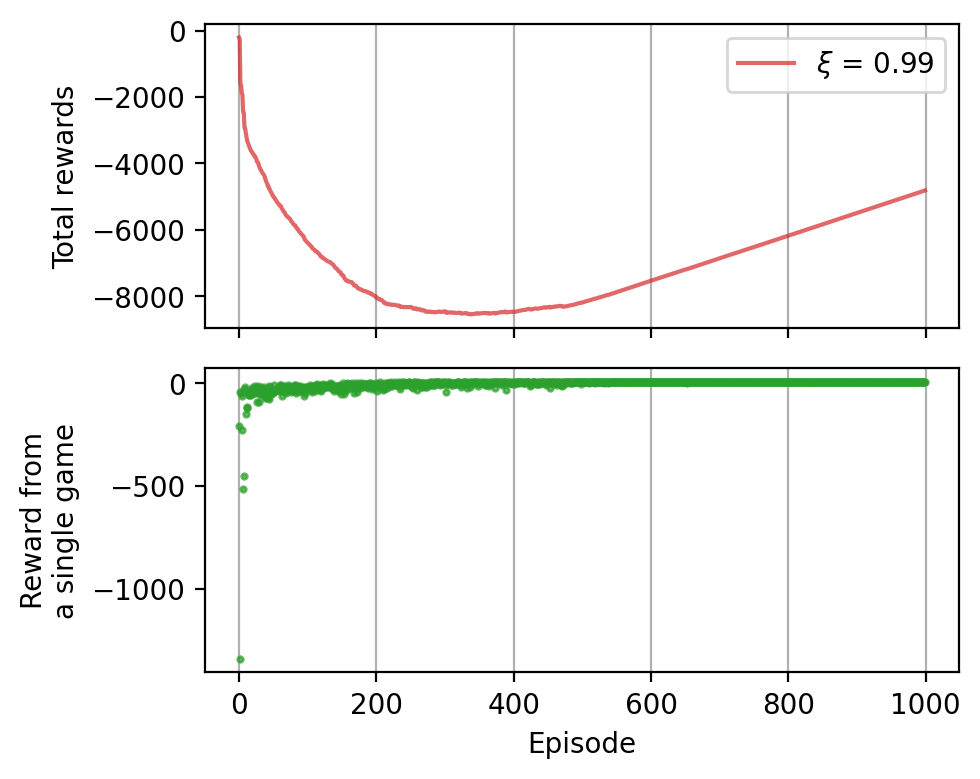

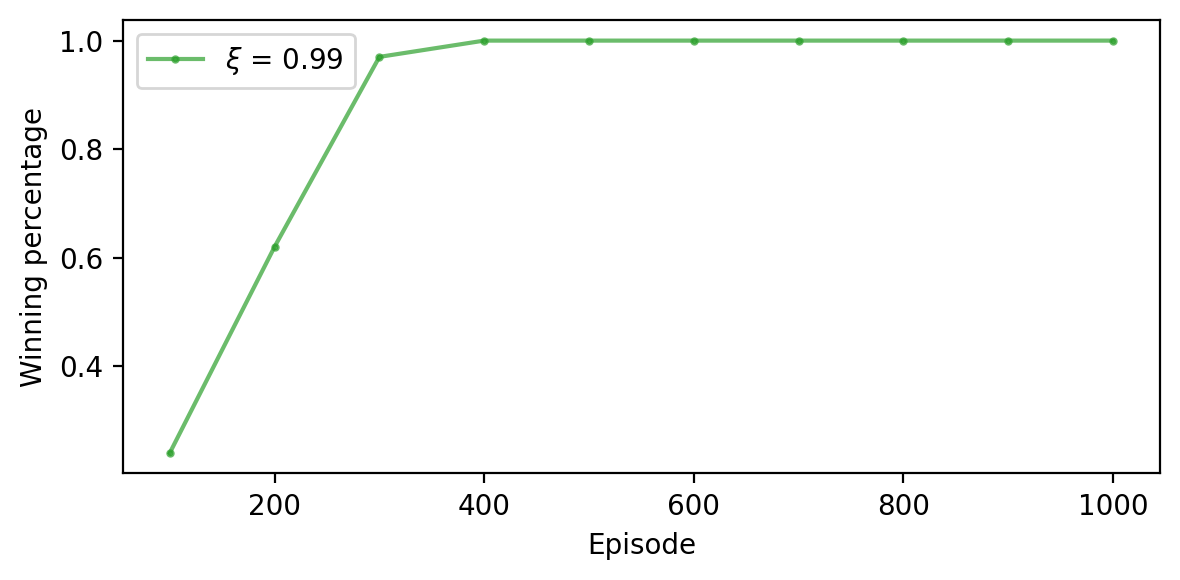

In [5]:
problem = GridWorld('world02.csv', reward={0: -0.04, 1: 10.0, 2: -2.5, 3: np.NaN}, random_rate=0.2)
problem_solver = GridWorldQSolver(problem, QLearner, epsilon=1.0, xi=0.99)
problem_solver.train(1000, start_pos=(5, 3), plot=True)

In this example, we can see from the tables that like many other ML agents, the agent starts out making strange choices and failing to reach the goal the majority of the time.  As the agent accumulates knowledge for its Q-Table though, we can see how the winning percentage rises to where the agent wins a vast majority of the time.

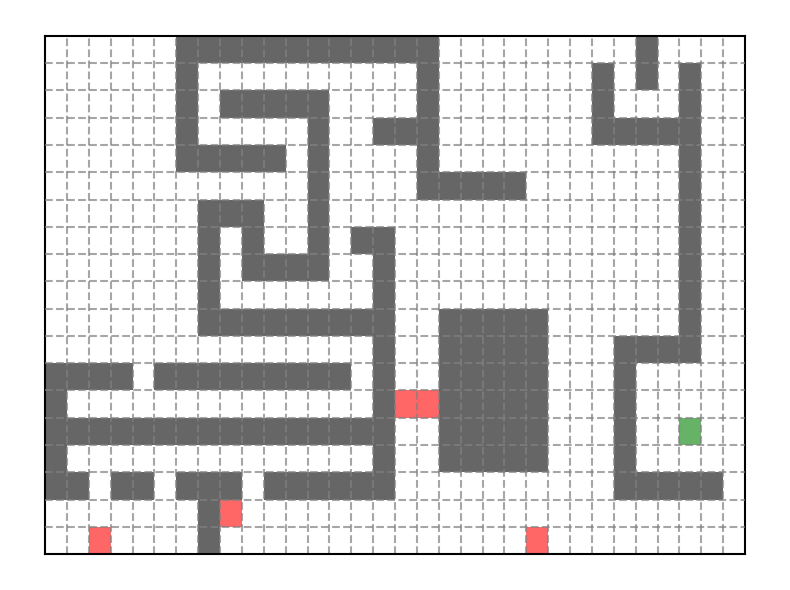

In [10]:
problem.plot_map()

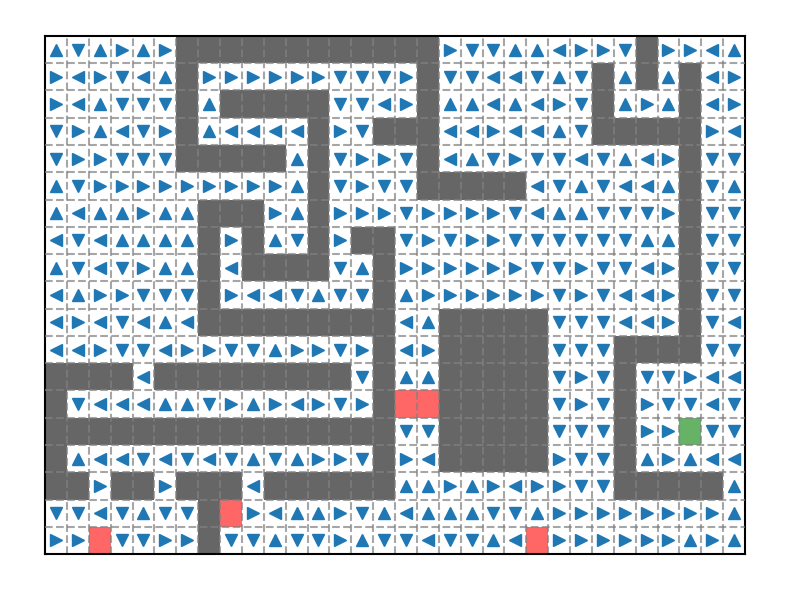

In [11]:
problem.plot_policy(policy=problem_solver.learner.cur_policy)